In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 200,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8580246913580247, Loss: 0.6199843088785807
Checkpoint 20, Accuracy: 0.8765432098765432, Loss: 0.5729131345395688
Checkpoint 30, Accuracy: 0.845679012345679, Loss: 0.5400112293384693
Checkpoint 40, Accuracy: 0.8395061728395061, Loss: 0.48507538548222295
Checkpoint 50, Accuracy: 0.9382716049382716, Loss: 0.42351945241292316
Checkpoint 60, Accuracy: 0.9629629629629629, Loss: 0.39415211147732204
Checkpoint 70, Accuracy: 0.9629629629629629, Loss: 0.32059065500895184
Checkpoint 80, Accuracy: 0.9506172839506173, Loss: 0.28481285660355177
Checkpoint 90, Accuracy: 0.9567901234567902, Loss: 0.23994770756474249
Checkpoint 100, Accuracy: 0.9753086419753086, Loss: 0.21374635343198423
Checkpoint 110, Accuracy: 0.9691358024691358, Loss: 0.17527165236296477
Checkpoint 120, Accuracy: 0.9753086419753086, Loss: 0.14982242937441226
Checkpoint 130, Accuracy: 0.9814814814814815, Loss: 0.13156981821413394
Checkpoint 140, Accuracy: 0.9629629629629629, Loss: 0.13422837963810674
Check

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9949744  0.00114778 0.00387779]
[1. 0. 0.] <-> [9.9648935e-01 9.7529852e-04 2.5353495e-03]
[0. 1. 0.] <-> [0.8149579  0.1831959  0.00184617]
[1. 0. 0.] <-> [0.9951008  0.00221564 0.00268357]
[1. 0. 0.] <-> [0.9966275  0.00163126 0.00174121]
[1. 0. 0.] <-> [0.9114009  0.00115039 0.08744873]
[1. 0. 0.] <-> [0.99618214 0.0021178  0.00170011]
[1. 0. 0.] <-> [1.9477746e-02 1.3578388e-05 9.8050874e-01]
[1. 0. 0.] <-> [9.7484958e-01 8.6547574e-04 2.4285011e-02]
[1. 0. 0.] <-> [9.5224661e-01 8.2423666e-04 4.6929128e-02]
[1. 0. 0.] <-> [9.7167945e-01 8.4791804e-04 2.7472591e-02]
[1. 0. 0.] <-> [0.9958931  0.0010993  0.00300754]
[1. 0. 0.] <-> [0.99686676 0.00117585 0.00195735]
[1. 0. 0.] <-> [0.99284256 0.00138115 0.00577639]
[0. 0. 1.] <-> [7.4226670e-03 4.9747314e-06 9.9257237e-01]
[1. 0. 0.] <-> [0.99653935 0.00180035 0.00166028]
[0. 1. 0.] <-> [1.5681332e-01 8.4274441e-01 4.4227470e-04]
[1. 0. 0.] <-> [0.9954543  0.00129905 0.00324658]
[0. 0. 1.] <-> [6.2069674e-03 4.08842

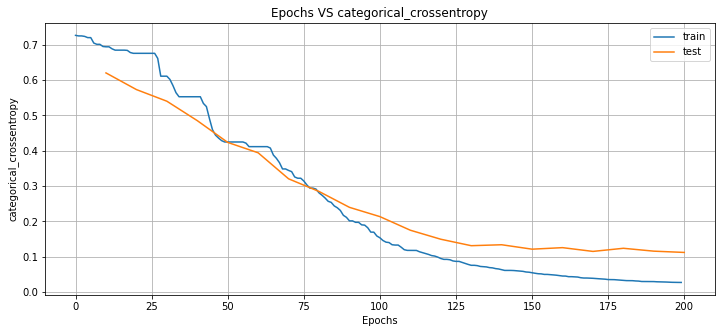

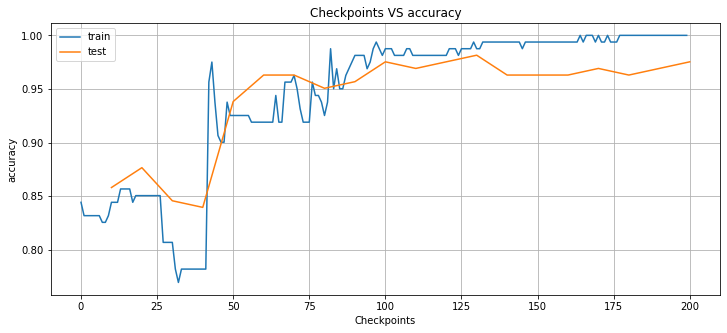

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8580246913580247, 'mean_square_error': 0.34259797266151865, 'categorical_crossentropy': 0.6199843088785807, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 23, 'tn_hit': 5, 'fn_hit': 0}, 1: {'tp_hit': 5, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 10}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 13}}, 'checkpoint': 10} 


{'accuracy': 0.8765432098765432, 'mean_square_error': 0.303076821249368, 'categorical_crossentropy': 0.5729131345395688, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 20, 'tn_hit': 8, 'fn_hit': 0}, 1: {'tp_hit': 8, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 7}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 13}}, 'checkpoint': 20} 


{'accuracy': 0.845679012345679, 'mean_square_error': 0.32669078424210723, 'categorical_crossentropy': 0.5400112293384693, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 25, 'tn_hit': 3, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}, 2: {'tp_hit': 3, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit':

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.23906699  3.         -0.701259   -2.184632   -3.        ]
 bias: 2.0529379844665527

Neuron 1: weights:
[ 1.7071227 -3.        -1.5772171 -3.         1.1260482]
 bias: 1.6498916149139404

Neuron 2: weights:
[ 2.1321514 -3.        -2.5527866 -1.7245997  3.       ]
 bias: 3.0

Neuron 3: weights:
[ 0.10034345  2.8918447   1.3288347  -1.5390859  -3.        ]
 bias: 3.0

$
Layer 2
Neuron 0: weights:
[3.       3.       3.       2.615456]
 bias: -3.0

Neuron 1: weights:
[ 3. -3. -3.  3.]
 bias: 1.6746143102645874

Neuron 2: weights:
[-3.         3.         2.0758526 -3.       ]
 bias: 3.0

$

